# Seismic post-stack inversion of Volve data

**Author: M.Ravasi**

In this notebook the sharp velocity model used for our various modelling steps is created by performing post-stack seismic inversion on the open-source Volve dataset.

More specifically, two main inputs available in the Volve data village are used here:

Whilst inversion is perfomed on a small 3D cube around a 2D slice of interest, a 2D velocity model is saved in .npz format for subsequent use. Note that the selected slice is the closest to a 2D receiver cable that we will be using for modelling purposes.

We cannot provide the data given its size, but the Volve data is hosted on a Azure Blob storage so it is very easy to download it using the Azure CLI (https://github.com/Azure/azure-cli or ``pip install azure-cli`` would do).

In [1]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA (DATA)
#!az storage blob download --account-name datavillagesa --container-name volve --name Seismic/ST10010/Stacks/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --file ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy ../Data/Original

In [2]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA (VELOCITY)
#!az storage blob download --account-name datavillagesa --container-name volve --name Seismic/ST10010/Velocities/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy --file ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy ../Data/Original

In [3]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA (SHOTS)
#az storage blob download --account-name datavillagesa --container-name volve --name Seismic/ST10010/Raw_data/ST10010+NAV_MERGE/ST10010_1150780_40203.sgy --file ST10010_1150780_40203.sgy --sas-token "$YOURTOKEN"
#!mv ST10010_1150780_40203.sgy ../Data/Original

where you will need to substitute ``$YOURTOKEN`` with your personal token. To get a token, simply register at https://data.equinor.com/authenticate and find the token in the red text in the Usage section. Ensure to copy everything from `?sv=` to `=rl` in place of ``$YOURTOKEN``.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import numpy as np
import segyio
import pylops
import matplotlib.pyplot as plt

from scipy.interpolate import RegularGridInterpolator
from segyshot import SegyShot

Let's start by defining some of the input parameters we will use for the inversion

In [5]:
# Area to invert
ilplot = 9999 # index of inline of interest
iloff = 10 # number of inlines to use in inversion

# Wavelet estimation
nt_wav = 21 # number of samples of statistical wavelet
nfft = 512 # number of samples of FFT

# Blocky simultaneous
niter_out_b = 3 # number of outer loop iterations
niter_in_b = 1 # number of inner loop iterations
niter_b = 10 # number of iterations of lsqr
mu_b = 1e-1 # damping for data term
epsI_b = 1e-4 # damping
epsR_b = 0.1 # spatial regularization
epsRL1_b = 1. # blocky regularization

## Data loading

Let's now read the Volve poststack data and put it into a regular grid

In [6]:
segyfile = '../Data/Original/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'
f = segyio.open(segyfile, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
ntraces, nz = traces.shape

z = f.samples
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dz = z[1] - z[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nz))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

We read also the migration velocity model and resample it to the grid of the data.

In [7]:
segyfilev = '../Data/Original/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
fv = segyio.open(segyfilev)
v = segyio.cube(fv)

IL, XL, T = np.meshgrid(ilines, xlines, z, indexing='ij')

vinterp = RegularGridInterpolator((fv.ilines, fv.xlines, fv.samples), v, 
                                  bounds_error=False, fill_value=0)
vinterp = vinterp(np.vstack((IL.ravel(), XL.ravel(), T.ravel())).T)
vinterp = vinterp.reshape(nil, nxl, nz)

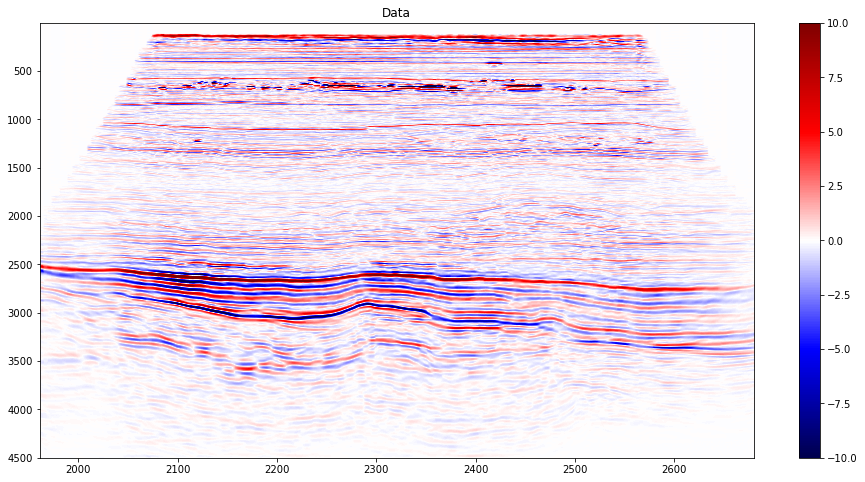

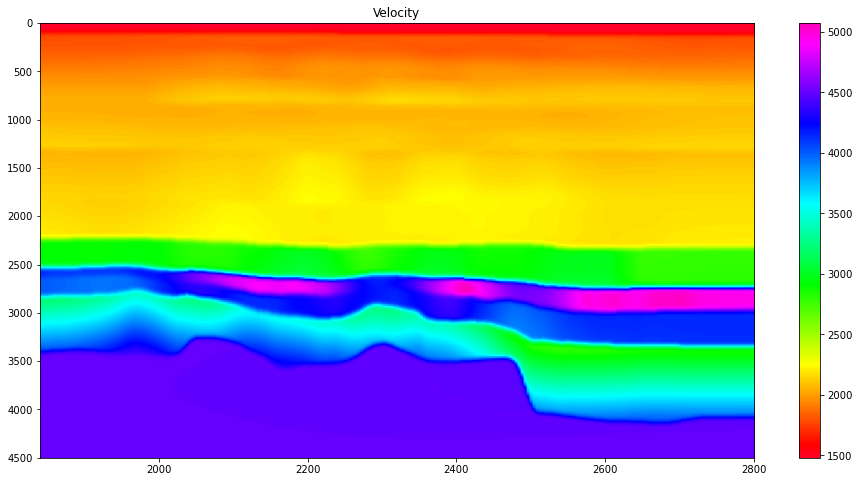

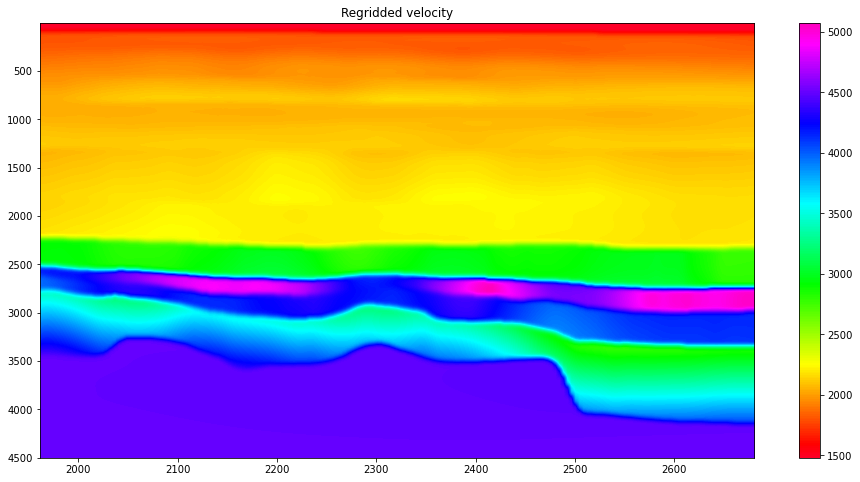

In [8]:
# Display data
iilplot_v = np.where(fv.ilines == ilplot)[0][0]
iilplot_d = np.where(ilines == ilplot)[0][0]

plt.figure(figsize=(16, 8))
plt.imshow(d[iilplot_d].T, cmap='seismic', vmin=-10, vmax=10,
           extent=(xlines[0], xlines[-1], z[-1], z[0]))
plt.title('Data')
plt.colorbar()
plt.axis('tight')

plt.figure(figsize=(16, 8))
plt.imshow(v[iilplot_v].T, cmap='gist_rainbow',
           extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
plt.title('Velocity')
plt.colorbar()
plt.axis('tight')

plt.figure(figsize=(16, 8))
plt.imshow(vinterp[iilplot_d].T, cmap='gist_rainbow',
           extent=(xlines[0], xlines[-1], z[-1], z[0]))
plt.title('Regridded velocity')
plt.colorbar()
plt.axis('tight');

We need now to scale this model to its acoustic impedance equivalent. 

This calibration step was performed outside of this notebook using a welllog and this velocity model along a well trajectory. In this example we will simply use a scaling (gradient) and a shift (intercept) from that study.

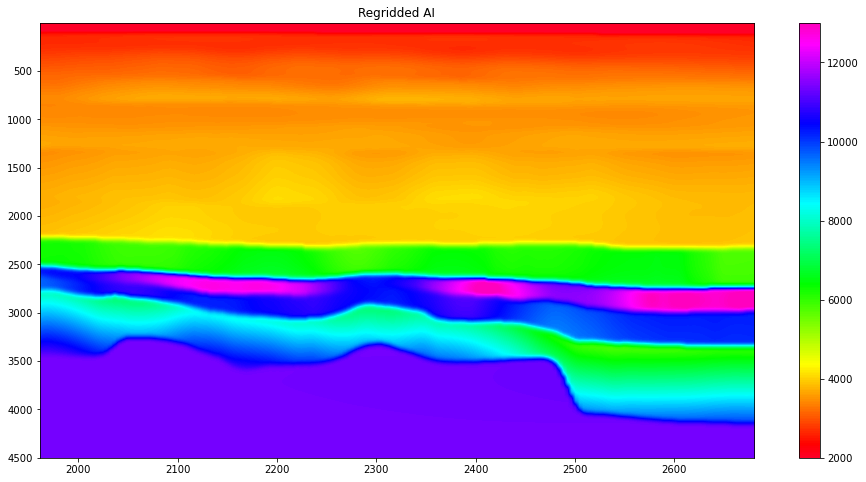

In [9]:
intercept = -3218.0003362662665
gradient = 3.2468122679241023

aiinterp = intercept + gradient*vinterp

# Display data
plt.figure(figsize=(16, 8))
plt.imshow(aiinterp[iilplot_d].T, cmap='gist_rainbow', vmin=2000, vmax=13000,
           extent=(xlines[0], xlines[-1], z[-1], z[0]))
plt.title('Regridded AI')
plt.colorbar()
plt.axis('tight');

## Inversion

Select area to invert

In [10]:
ilinvert = ilines[iilplot_d-iloff//2:iilplot_d+iloff//2]

d = d[iilplot_d-iloff//2:iilplot_d+iloff//2]
aiinterp = aiinterp[iilplot_d-iloff//2:iilplot_d+iloff//2]

Let's now try to get a quick estimate of the wavelet in our data using a simple statistical wavelet estimation in frequency domain.

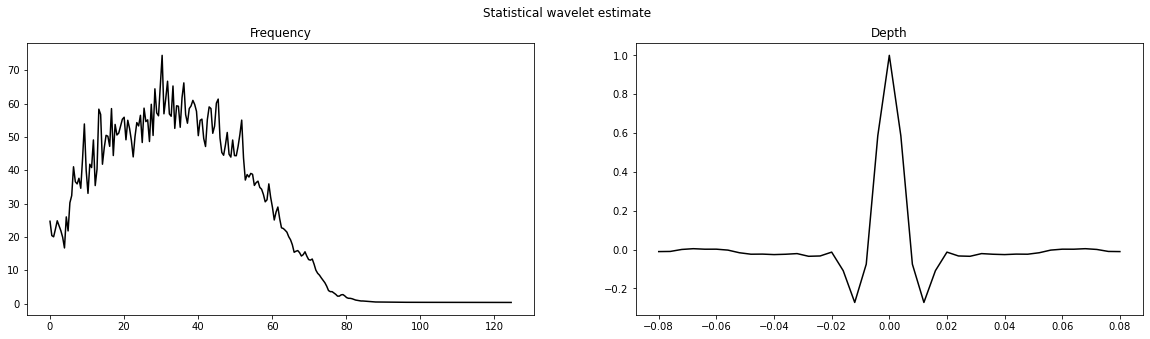

In [11]:
# Wavelet 'depth' axis
t_wav = np.arange(nt_wav) * (dz/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[::2, ::2], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dz/1000)

# Create wavelet in depth
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Depth');

We can apply seismic inversion using a starting background AI model. The inverted AI model will therefore have the correct physical quantities of acoustic impedance.

In [12]:
# Swap depth axis back to first dimension
d = np.swapaxes(d, -1, 0)
aiinterp = np.swapaxes(aiinterp, -1, 0)

m0 = np.log(aiinterp)
m0[np.isnan(m0)] = 0

# Inversion
m_abs, r_abs = \
    pylops.avo.poststack.PoststackInversion(d, 1e1*wav_est, m0=m0, explicit=False, 
                                            epsR=epsR_b, epsRL1=epsRL1_b,
                                            **dict(mu=mu_b, niter_outer=niter_out_b, 
                                                   niter_inner=niter_in_b, show=True,
                                                   iter_lim=niter_b, damp=epsI_b))

# Swap depth axis back to last dimension
aiinterp = np.swapaxes(aiinterp, 0, -1)
d = np.swapaxes(d, 0, -1)
m_abs = np.swapaxes(np.exp(m_abs), 0, -1)
r_abs = np.swapaxes(r_abs, 0, -1)

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 8100000 rows and 8100000 cols
niter_outer =   3     niter_inner =   1   tol = 1.00e-10
mu = 1.00e-01         epsL1 = [1.0]	  epsL2 = [0.1]     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   7.34465e+00        4.633e+04        4.684e+05
     2   7.41110e+00        2.836e+04        4.299e+05
     3   7.46146e+00        2.647e+04        4.180e+05

Iterations = 3        Total time (s) = 85.59
---------------------------------------------------------



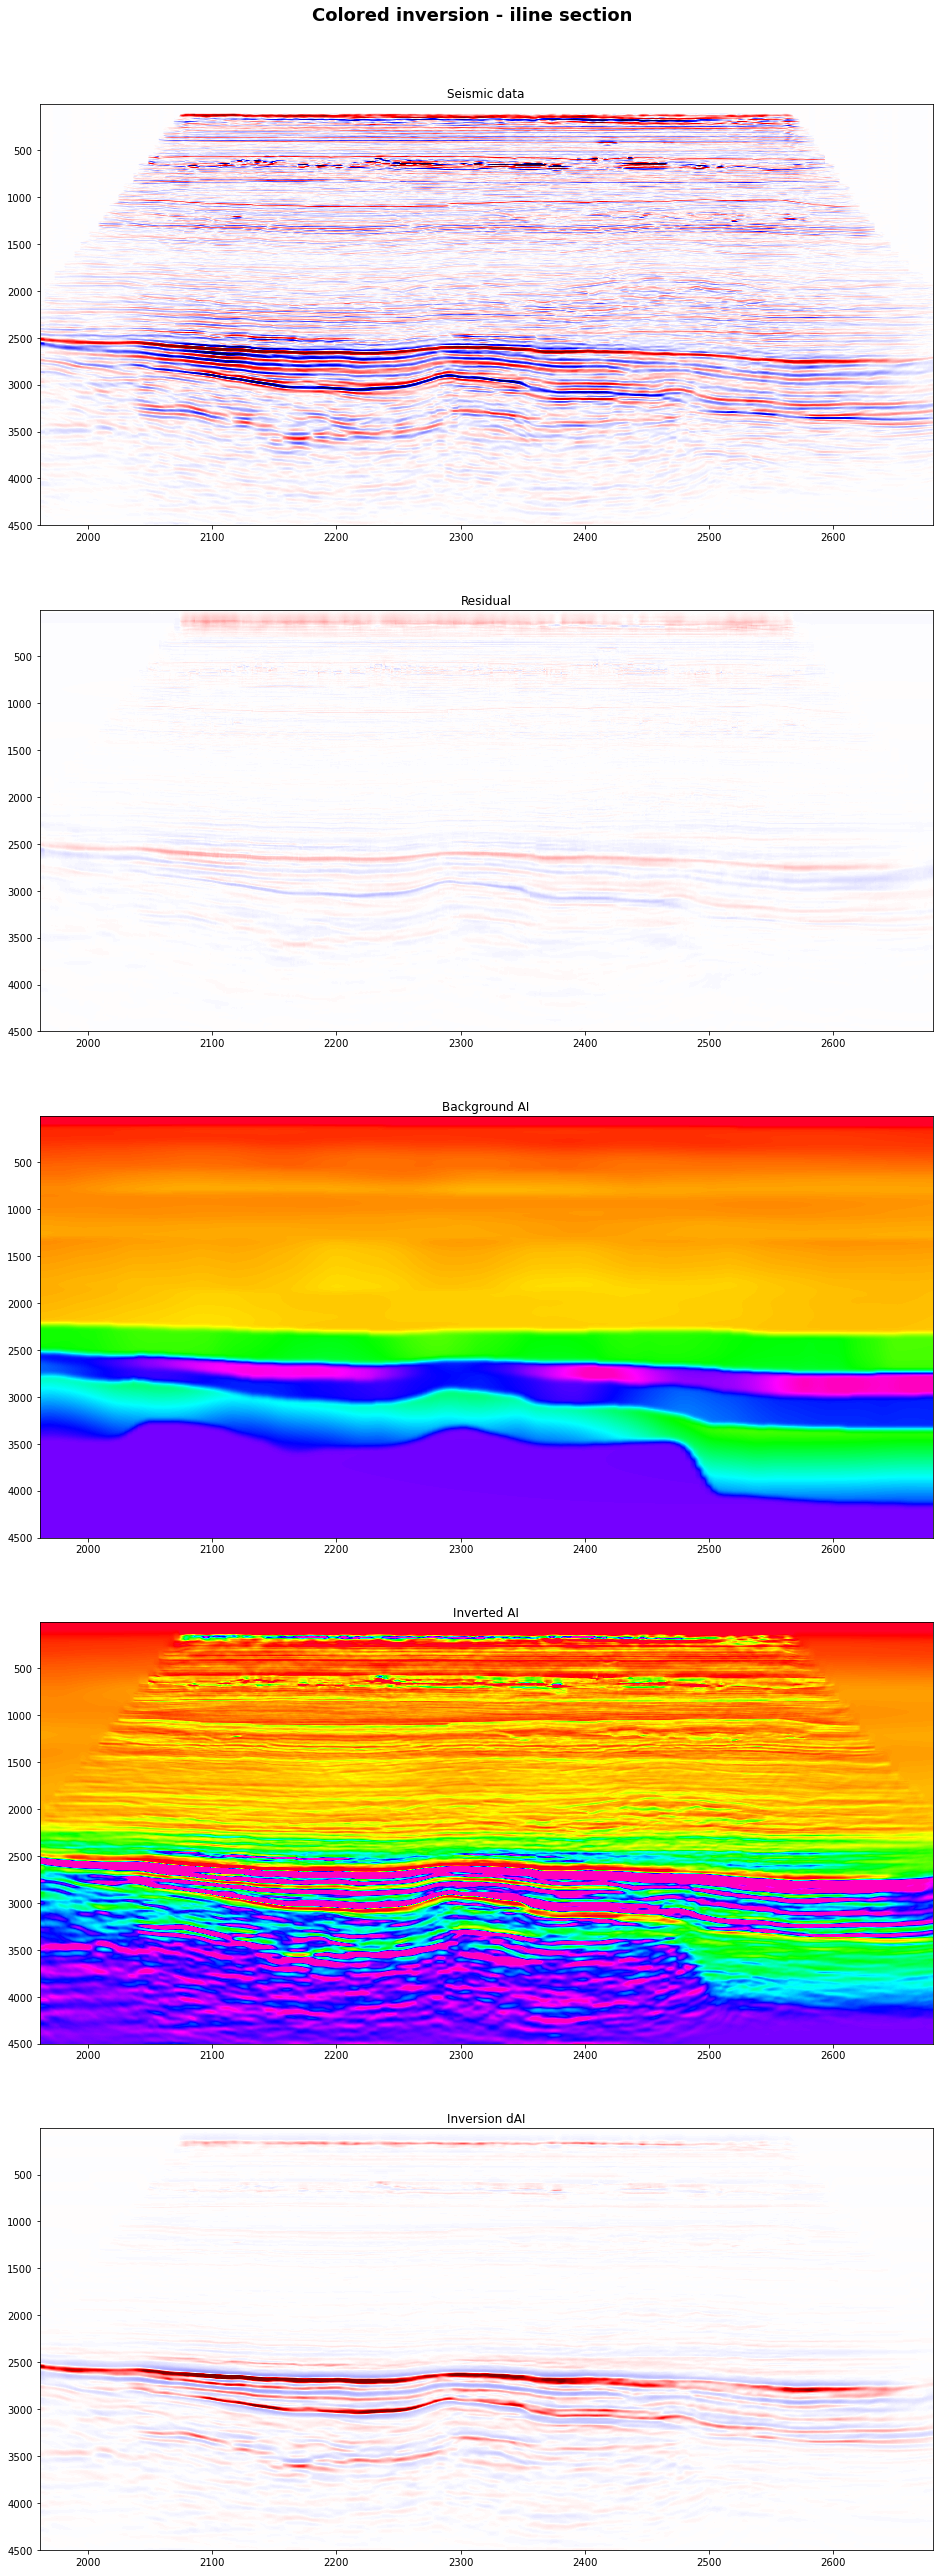

In [13]:
# Display inversion
fig, axs = plt.subplots(5, 1, figsize=(16, 45))
fig.suptitle('Colored inversion - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d[iloff//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], z[-1], z[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(r_abs[iloff//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], z[-1], z[0]))
axs[1].set_title('Residual')
axs[1].axis('tight')
axs[2].imshow(aiinterp[iloff//2].T, cmap='gist_rainbow',
              vmin=2000, vmax=13000,
              extent=(xlines[0], xlines[-1], z[-1], z[0]))
axs[2].set_title('Background AI')
axs[2].axis('tight')
axs[3].imshow(m_abs[iloff//2].T, cmap='gist_rainbow',
              vmin=2000, vmax=13000,
              extent=(xlines[0], xlines[-1], z[-1], z[0]))
axs[3].set_title('Inverted AI')
axs[3].axis('tight');
axs[4].imshow(m_abs[iloff//2].T -  aiinterp[iloff//2].T, cmap='seismic',
          vmin=-0.1*(m_abs- aiinterp).max(), vmax=0.1*(m_abs- aiinterp).max(),
          extent=(xlines[0], xlines[-1], z[-1], z[0]))
axs[4].set_title('Inversion dAI')
axs[4].axis('tight');

## Velocity model preparation

Finally we rescale our inversion back to velocities, perform a few corrections (eg. remove too high velocities and extract the inverted velocity at slice of interest)

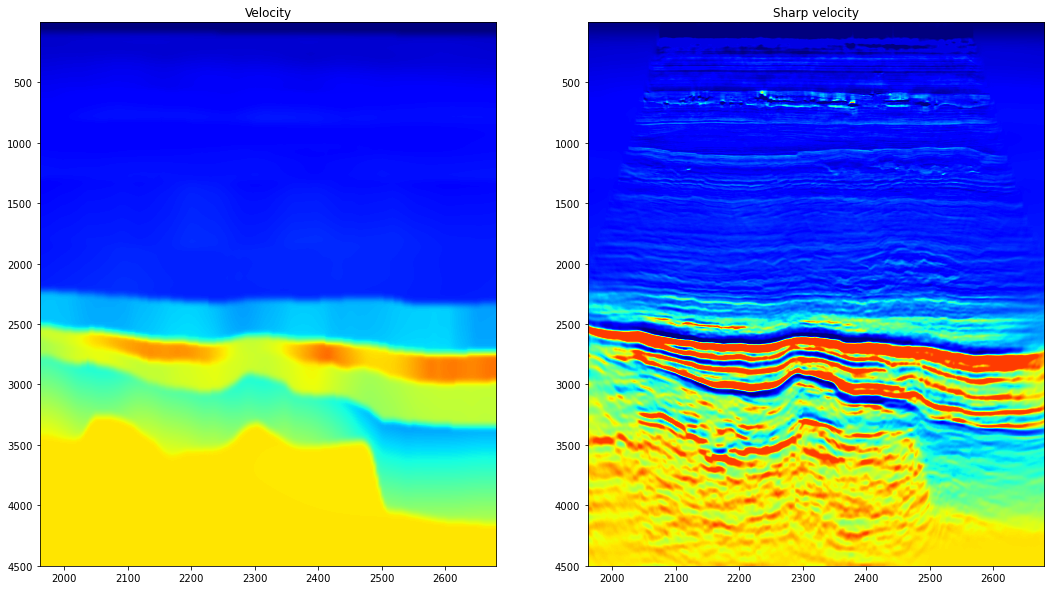

In [14]:
# Rescale to velocity
vpinv = (m_abs-intercept)/gradient

# Remove unreasonably high contrasts
vpinv[vpinv>5300] = 5300

# Remove artefacts near seabed
vpinv[..., :70][vpinv[..., :70]>2000] = 1900

fig, axs = plt.subplots(1, 2, figsize=(18, 10))
axs[0].imshow(vinterp[iilplot_d].T, cmap='jet', vmin=1500, vmax=6000,
           extent=(xlines[0], xlines[-1], z[-1], z[0]))
axs[0].set_title('Velocity')
axs[0].axis('tight')
axs[1].imshow(vpinv[iloff//2].T, cmap='jet', vmin=1500, vmax=6000,
           extent=(xlines[0], xlines[-1], z[-1], z[0]))
axs[1].set_title('Sharp velocity')
axs[1].axis('tight');

We are almost ready to save our velocity model but we want to also define a set of sources and receivers in agreement with the real acquisition geometry. Moreover, to simplify our life during modelling and inversion we want to transform everything onto a local cartesian system of coordinates.

In [15]:
# Extract velocity model il-xl coordinates for regredding
vmodtr = segyio.collect(fv.trace[:])
ilvel, xlvel, zvel = fv.ilines, fv.xlines, fv.samples
ilsvel, xlsvel = fv.attributes(segyio.TraceField.INLINE_3D)[:], fv.attributes(segyio.TraceField.CROSSLINE_3D)[:]

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


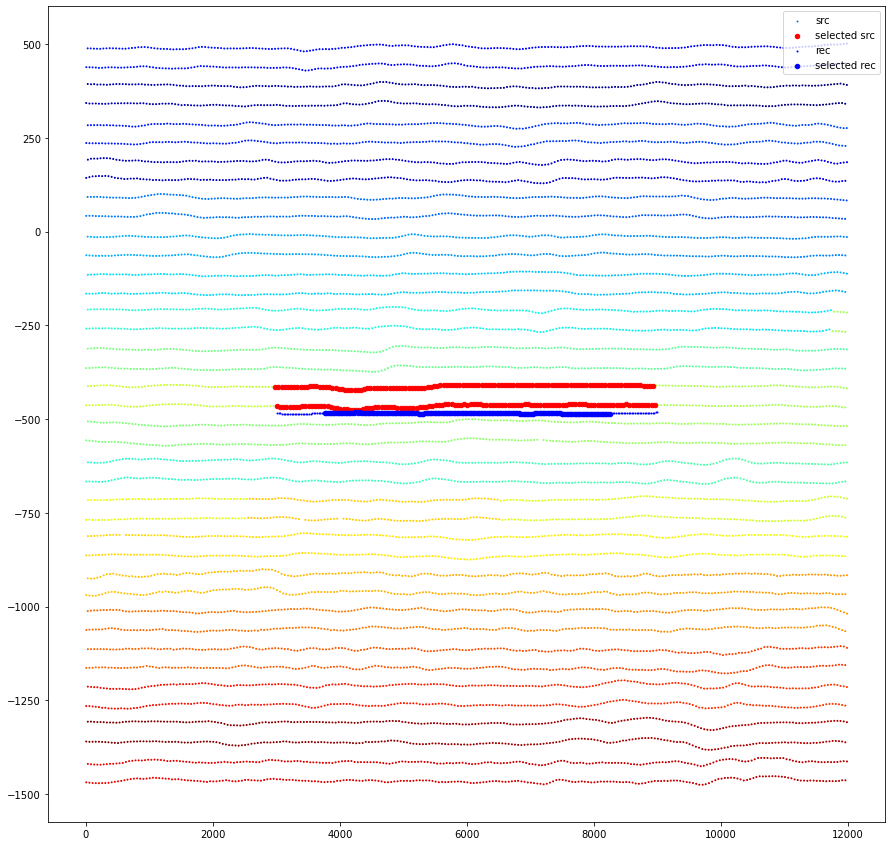

In [16]:
# Extract acquisition geometry along selected 2D line
ishotc = 5520
ishotin, ishotend = ishotc-120, ishotc+120
irecin, irecend = 30, 210

sg = SegyShot('../Data/Original/ST10010_1150780_40203.sgy', components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()

_,_,_,_, (xvel_local, yvel_local) = sg.rotategeometry(velfile=segyfilev, plotflag=0)
sg.selectrecs(irecin, irecend, plotflag=False)
sg.selectsrcs(ishotin, ishotend, plotflag=False)
sg.showgeometry(local=True, figsize=(15, 15))

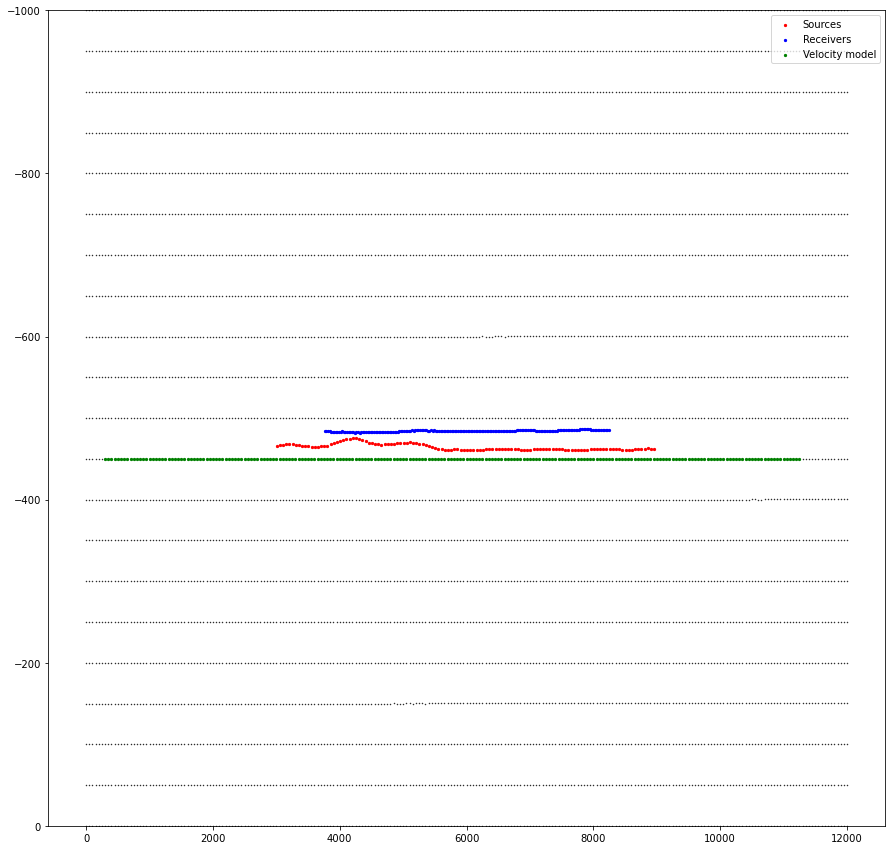

In [17]:
# Choosing velocity line, sources and receivers for imaging
iyvel = np.argmin(np.abs(yvel_local - sg.srcy_local[ishotc]))
nyvel = 220

plt.figure(figsize=(15, 15))
plt.scatter(sg.srcx_local[ishotc-120:ishotc+120:2], sg.srcy_local[ishotc-120:ishotc+120:2],
            c='r', s=5, label='Sources')
plt.scatter(sg.recx_local[sg.selected_rec], sg.recy_local[sg.selected_rec], 
            c='b', s=5, label='Receivers')
plt.scatter(xvel_local, yvel_local, c='k', s=.2)
plt.scatter(xvel_local[iyvel:iyvel+nyvel], yvel_local[iyvel:iyvel+nyvel], c='g', s=5, label='Velocity model')
plt.ylim(0,-1000)
plt.legend();

In [18]:
# Interpolate original velocity model over finer grid and extract mask of sea
dx = np.round(np.mean(np.diff(xvel_local[iyvel:iyvel+nyvel])))
dz = zvel[1] - zvel[0]
dxint, dzint = 5, 5
xint = np.arange(xvel_local[iyvel], xvel_local[iyvel+nyvel-1], dxint)
zint = np.arange(zvel[0], zvel[-1], dzint)
nxint, nzint = len(xint), len(zint)
X, Z = np.meshgrid(xint, zint, indexing='ij')
XZ = np.vstack((X.ravel(), Z.ravel())).T

interpolator = RegularGridInterpolator((xvel_local[iyvel:iyvel+nyvel], zvel), vmodtr[iyvel:iyvel+nyvel], 
                                       bounds_error=False, fill_value=0)
vmodtrint = interpolator(XZ).astype(np.float32)
vmodtrint = vmodtrint.reshape(nxint, nzint).T
vmodtrint[vmodtrint<1580] = 1480
vmodtrint[(vmodtrint>1580) &(vmodtrint<1800) ] = 1800

vmodtrint_seamask = np.zeros_like(vmodtrint)
vmodtrint_seamask[vmodtrint<=1480] = 1

In [19]:
# Finalize velocity model over single 2d line
x_inv = np.interp(xlines, xlsvel[iyvel:iyvel+nyvel], xvel_local[iyvel:iyvel+nyvel])
interpolator = RegularGridInterpolator((x_inv, z), vpinv[iloff//2], bounds_error=False, fill_value=0)
vinvrint = interpolator(XZ).astype(np.float32)
vinvrint = vinvrint.reshape(nxint, nzint).T

# Small adjustments to recreate sharp seabed
vinvrint[vmodtrint_seamask==1] = 1480
vinvrint[:33][vmodtrint_seamask[:33]==0] = 1900

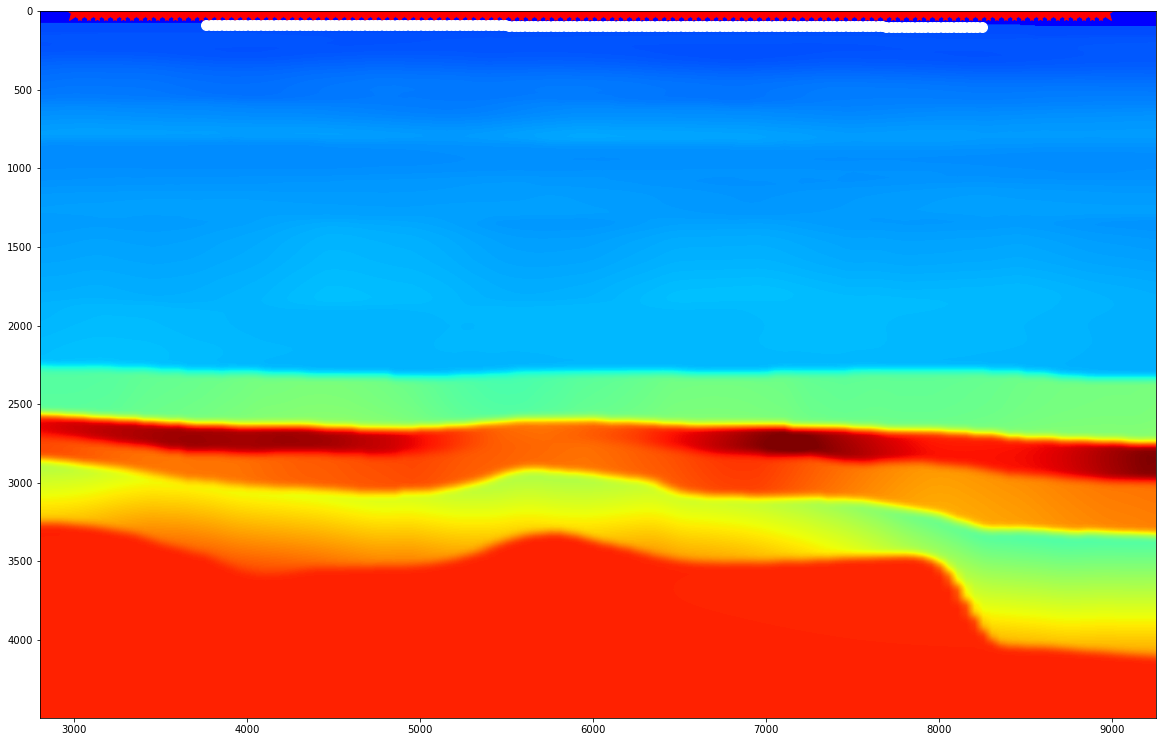

In [20]:
plt.figure(figsize=(20, 13))
plt.imshow(vmodtrint[:, 500:-400], cmap='jet', vmin=1000, vmax=5000, 
           extent=(xint[500], xint[-400], zint[-1], zint[0]))
plt.plot(sg.srcx_local[ishotc-120:ishotc+120:2], sg.srcz[ishotc-120:ishotc+120:2], '*r', ms=20)
plt.plot(sg.recx_local[sg.selected_rec], sg.recz[sg.selected_rec], '.w', ms=20)
plt.axis('tight');

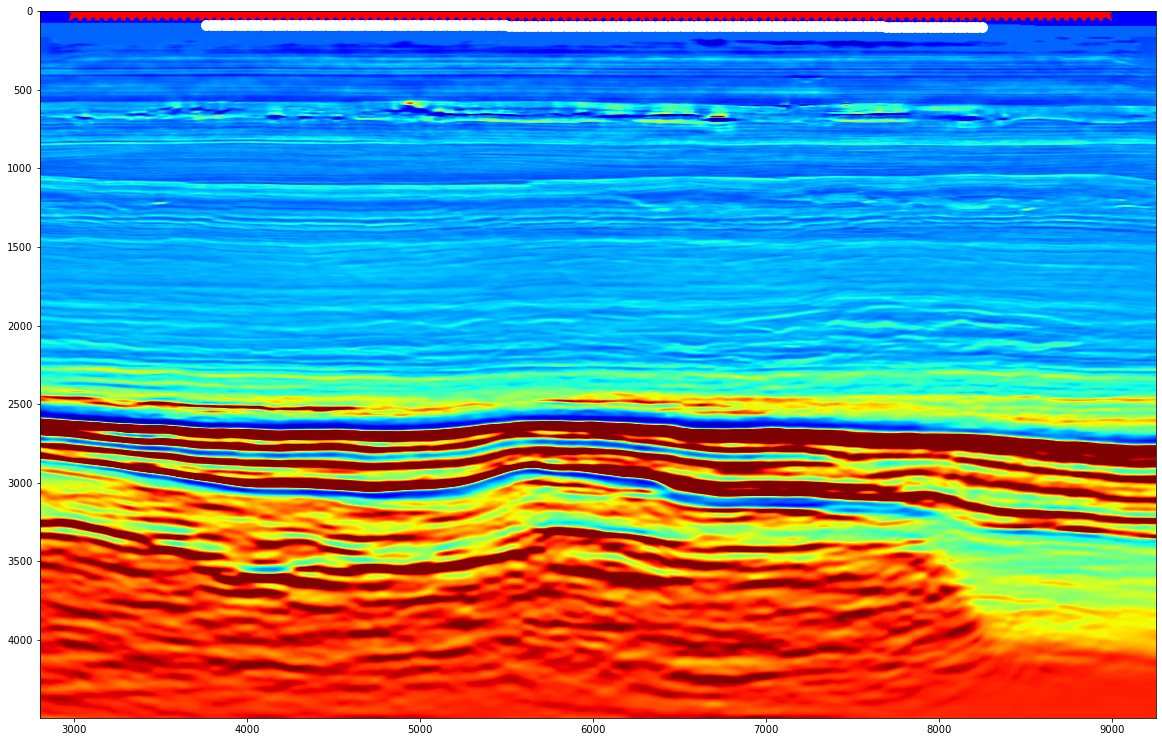

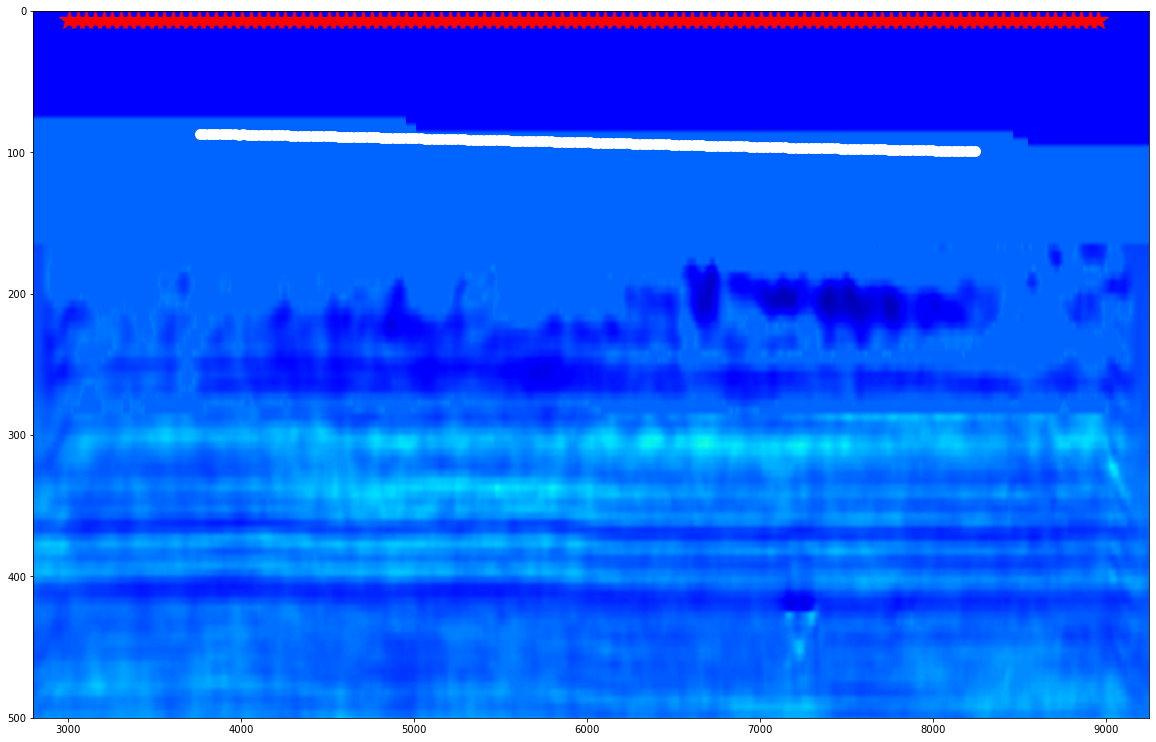

In [34]:
plt.figure(figsize=(20, 13))
plt.imshow(vinvrint[:, 500:-400], cmap='jet', vmin=1000, vmax=5000, 
           extent=(xint[500], xint[-400], zint[-1], zint[0]))
plt.plot(sg.srcx_local[ishotc-120:ishotc+120:2], sg.srcz[ishotc-120:ishotc+120:2], '*r', ms=20)
plt.plot(sg.recx_local[sg.selected_rec], sg.recz[sg.selected_rec], '.w', ms=20)
plt.axis('tight')

plt.figure(figsize=(20, 13))
plt.imshow(vinvrint[:, 500:-400], cmap='jet', vmin=1000, vmax=5000, 
           extent=(xint[500], xint[-400], zint[-1], zint[0]))
plt.plot(sg.srcx_local[ishotc-120:ishotc+120:2], sg.srcz[ishotc-120:ishotc+120:2], '*r', ms=20)
plt.plot(sg.recx_local[sg.selected_rec], sg.recz[sg.selected_rec], '.w', ms=20)
plt.axis('tight')
plt.ylim(500, 0);

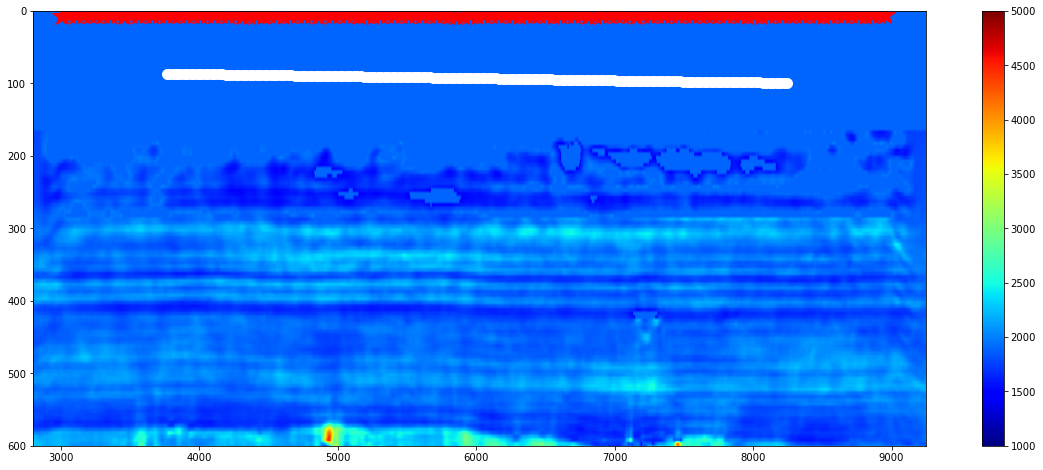

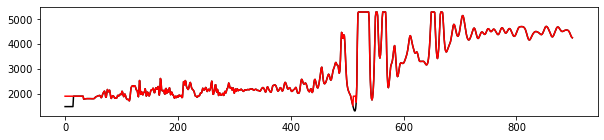

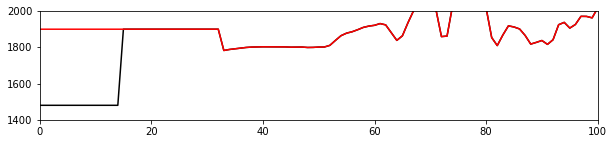

In [22]:
# Create model without sea layer
vinvtrint_nosea = vinvrint.copy()
vinvtrint_nosea[vinvtrint_nosea<1500] = 1900

plt.figure(figsize=(20, 8))
plt.imshow(vinvtrint_nosea[:, 500:-400], cmap='jet', vmin=1000, vmax=5000, 
           extent=(xint[500], xint[-400], zint[-1], zint[0]))
plt.plot(sg.srcx_local[ishotc-120:ishotc+120:2], sg.srcz[ishotc-120:ishotc+120:2], '*r', ms=20)
plt.plot(sg.recx_local[sg.selected_rec], sg.recz[sg.selected_rec], '.w', ms=20)
plt.axis('tight');
plt.ylim(600, 0)
plt.colorbar()

plt.figure(figsize=(10, 2))
plt.plot(vinvrint[:, 500], 'k')
plt.plot(vinvtrint_nosea[:, 500], 'r')

plt.figure(figsize=(10, 2))
plt.plot(vinvrint[:, 500], 'k')
plt.plot(vinvtrint_nosea[:, 500], 'r')
plt.xlim(0, 100)
plt.ylim(1400, 2000);

## Save

In [36]:
outfile = '../Data/Velocity/vel.bin'
with open(outfile, 'wb') as f: # write for madagascar
    vinvrint[:, 500:-400].T.ravel().astype(np.float32).tofile(f)

outfile = '../Data/Velocity/vel_inv.bin'
with open(outfile, 'wb') as f: # write for madagascar
    vinvrint.T.ravel().astype(np.float32).tofile(f)

outfile = '../Data/Velocity/vel_inv_nosea.bin'
with open(outfile, 'wb') as f: # write for madagascar
    vinvtrint_nosea.T.ravel().astype(np.float32).tofile(f)

sfile = '../Data/Velocity/s.bin'
with open(sfile, 'wb') as f: # write for madagascar
    srcs = np.flipud(np.vstack((sg.srcx_local[ishotc-120:ishotc+120:2], sg.srcz[ishotc-120:ishotc+120:2])).T)
    srcs.ravel().astype(np.float32).tofile(f)
    
rfile = '../Data/Velocity/r.bin'
with open(rfile, 'wb') as f: # write for madagascar
    recs = np.flipud(np.vstack((sg.recx_local[sg.selected_rec], sg.recz[sg.selected_rec])).T)
    recs.ravel().astype(np.float32).tofile(f);

In [37]:
np.savez('../Data/Velocity/Velocities', vback=vmodtrint[:, 500:-400], v=vinvrint[:, 500:-400], 
         vnosea=vinvtrint_nosea[:, 500:-400], x=xint[500:-400], z=zint, xl=xlines, srcs=srcs, recs=recs)